In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from utils import *
import os

sns.set(style='whitegrid') # Set seaborn style for better visuals

### DBSCAN Logic:

In [2]:
# Function to run DBSCAN and evaluate + visualize results, calling methods from utils.py
def run_dbscan(X, y_true, eps=0.5, min_samples=5, title=''):
    # Standardize features 
    X_scaled = StandardScaler().fit_transform(X)
    
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = dbscan.fit_predict(X_scaled)
    
    # Number of clusters and noise points
    n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0) # number of clusters excluding noise 'cluster'
    n_noise = list(y_pred).count(-1) 

    # Visualization
    visualize_clustering_results(X_scaled, y_pred, y_true, title=title, reduce_dim=(X.shape[1] > 2))

    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")
    print("---------------------------------------------")
    
    # Evaluation Metrics
    evaluate_clustering(X_scaled, y_pred, y_true, n_clusters, title=title)
    
    return dbscan


### Setup datasets and hyperparameters:

In [3]:
datasets_dir = 'datasets'
datasets = [
    ('isotropic_blobs.csv', {'eps': 0.5, 'min_samples': 15}, 'Isotropic Gaussian Blobs'),
    ('anisotropic_blobs.csv', {'eps': 0.5, 'min_samples': 20}, 'Anisotropic Gaussian Blobs'),
    ('moons_circles.csv', {'eps': 0.2, 'min_samples': 20}, 'Moons and Circles'),
    ('overlapping_clusters.csv', {'eps': 0.6, 'min_samples': 20}, 'Overlapping Clusters'),
    ('high_dimensional_data.csv', {'eps': 2.0, 'min_samples': 20}, 'High-Dimensional Data with Noise')
]

### Main Driver Code:


Processing Isotropic Gaussian Blobs...


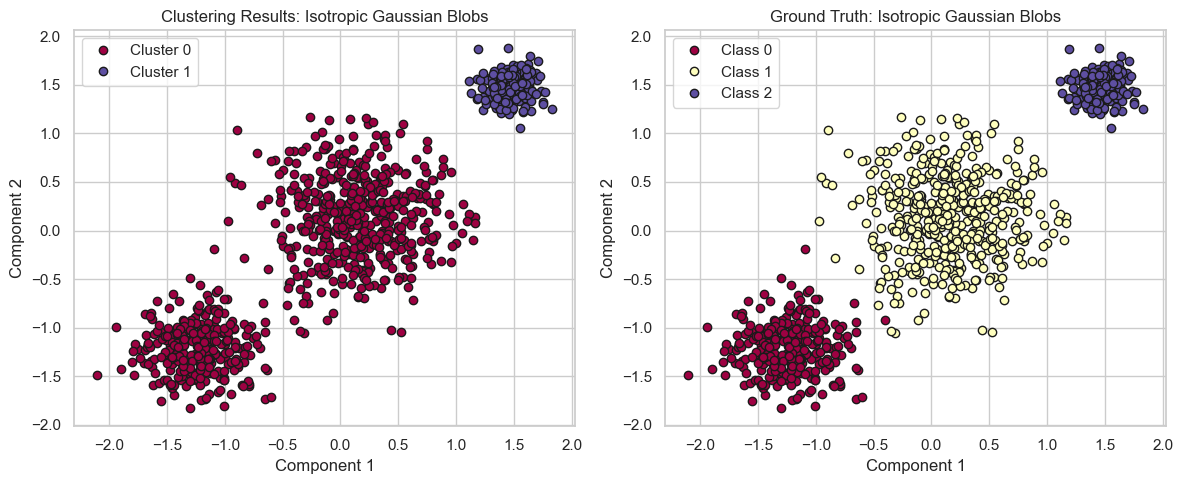

Estimated number of clusters: 2
Estimated number of noise points: 0
---------------------------------------------
Isotropic Gaussian Blobs
Adjusted Mutual Information: 0.6536
V-measure: 0.6541
Silhouette Score: 0.5386

Processing Anisotropic Gaussian Blobs...


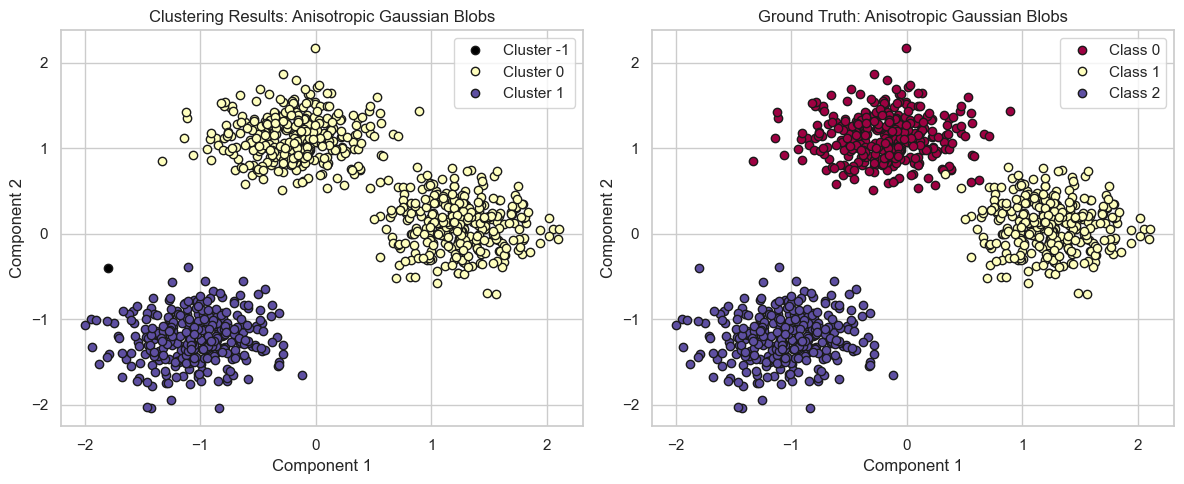

Estimated number of clusters: 2
Estimated number of noise points: 1
---------------------------------------------
Anisotropic Gaussian Blobs
Adjusted Mutual Information: 0.7300
V-measure: 0.7306
Silhouette Score: 0.6249

Processing Moons and Circles...


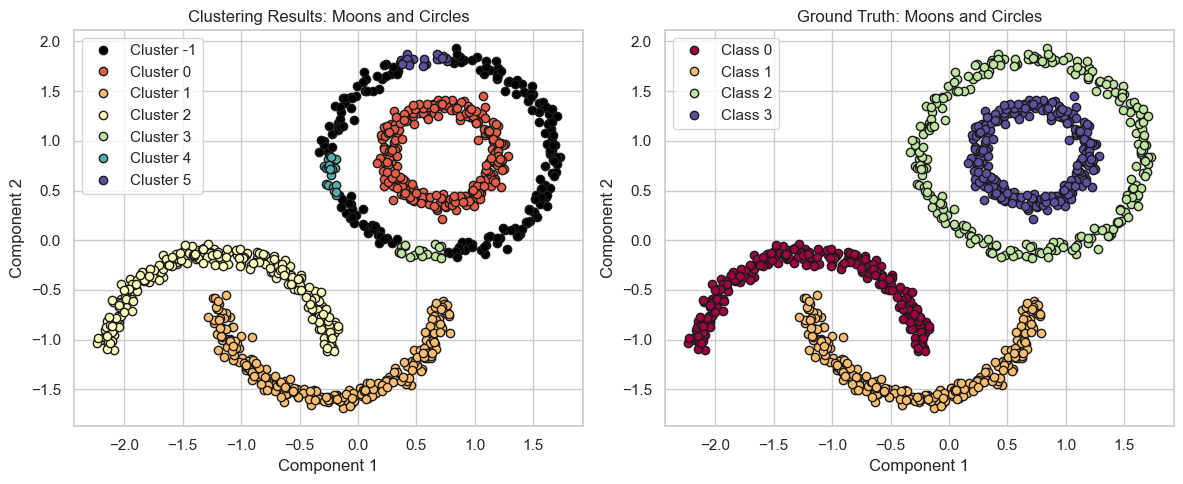

Estimated number of clusters: 6
Estimated number of noise points: 190
---------------------------------------------
Moons and Circles
Adjusted Mutual Information: 0.9311
V-measure: 0.9316
Silhouette Score: 0.2173

Processing Overlapping Clusters...


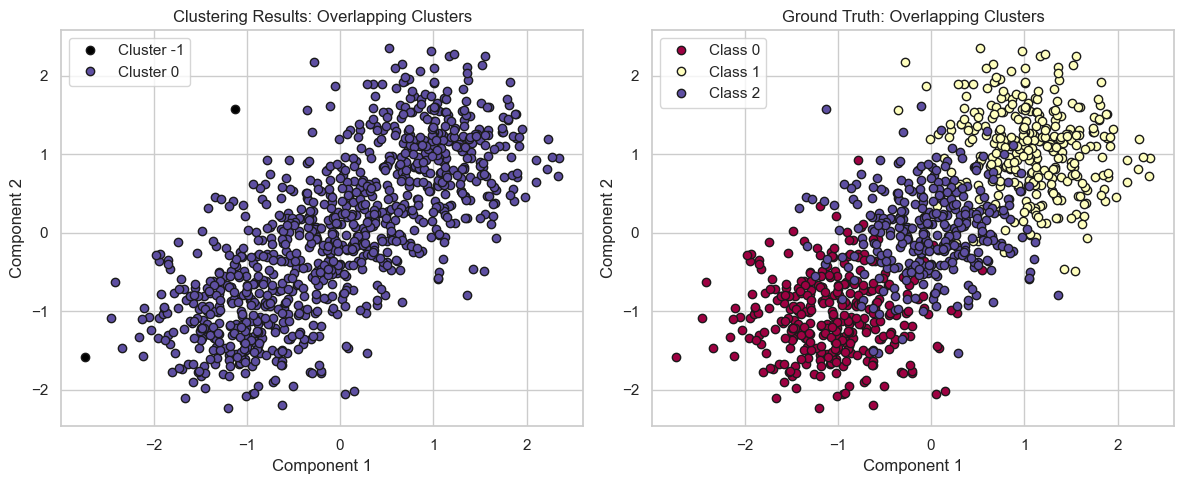

Estimated number of clusters: 1
Estimated number of noise points: 2
---------------------------------------------
Overlapping Clusters
Adjusted Mutual Information: -0.0008
V-measure: 0.0015
Silhouette Score: Cannot be calculated with less than 2 clusters.

Processing High-Dimensional Data with Noise...
Data will be reduced to 2D using PCA for visualization.


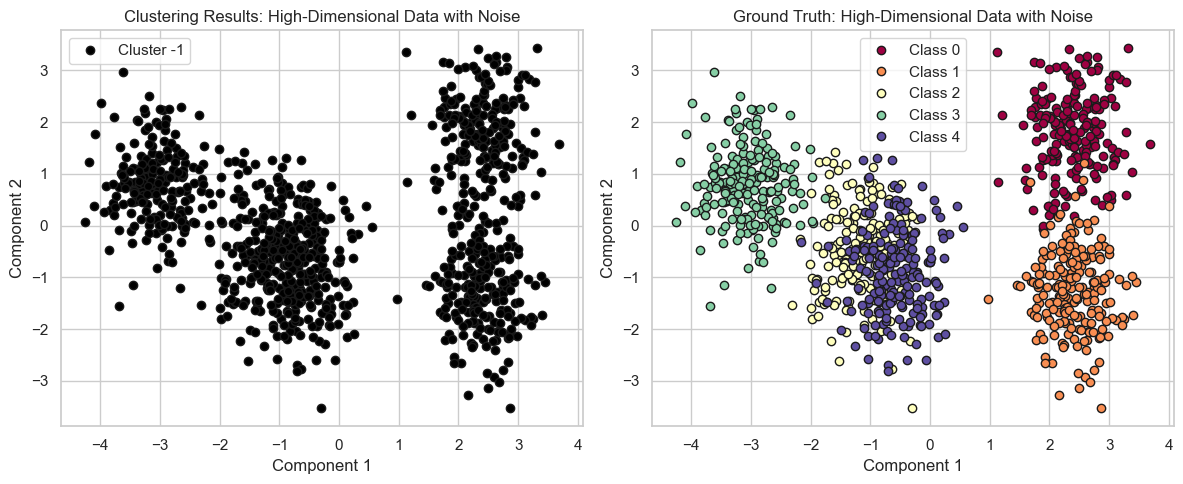

Estimated number of clusters: 0
Estimated number of noise points: 1000
---------------------------------------------
High-Dimensional Data with Noise
Adjusted Mutual Information: 0.0000
V-measure: 0.0000
Silhouette Score: Cannot be calculated with less than 2 clusters.


In [4]:
# Run DBSCAN for each dataset
for filename, params, title in datasets:
    print(f"\nProcessing {title}...")
    filepath = os.path.join(datasets_dir, filename)
    X, y_true = load_dataset(filepath)
    dbscan = run_dbscan(X, y_true, eps=params['eps'], min_samples=params['min_samples'], title=title)